In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from FVM_1D_jan2025 import fvm_1D
from coPINN_1D_Robin_Jan2025 import coPINN_1D_Solver

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# device1 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# device2 = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [17]:
L = 1.0

c_1 = 0.1 
c_2 = 10

h_c = 0.1
T_a = 300.0

alpha = 0.01
beta = 0.01

C_left = 2
C_right = 0

tol_T = 1e-4
tol_C = 1e-5


def S(T):
    # return c_1*(-np.abs(np.sin(T)))
    return c_1*(-T/1000.0)

def Q(C):
    return c_2*(-1 + -1*np.abs(np.cos(C)))

def S_torch(T):
    return c_1*(-T/1000.0)

def Q_torch(C):
    return c_2*(-1 + -1*torch.abs(torch.cos(C)))

pde_related_funcs = {"heat_source_func":Q,"heat_source_func_torch":Q_torch,"conc_force_func":S,"conc_force_func_torch":S_torch}

problem_constants = {"L":L,"alpha":alpha,"beta":beta,"h_c":h_c,"T_a":T_a,"C_left":C_left,"C_right":C_right}

In [18]:
N_x_1 = 100 #low must be 500 TAKES APPROX 40 SECONDS

T_FVM_1, C_FVM_1 = fvm_1D(pde_related_funcs,problem_constants,N_x_1,tol_T,tol_C)


T_FVM_norm_1 = np.linalg.norm(T_FVM_1,2)
C_FVM_norm_1 = np.linalg.norm(C_FVM_1,2)

T_FVM_1 = T_FVM_1[:-1]
fvm_results_1 = {'T_FVM': T_FVM_1,'C_FVM':C_FVM_1,"T_FVM_norm":T_FVM_norm_1,"C_FVM_norm":C_FVM_norm_1}

Elapsed Time 2.789727


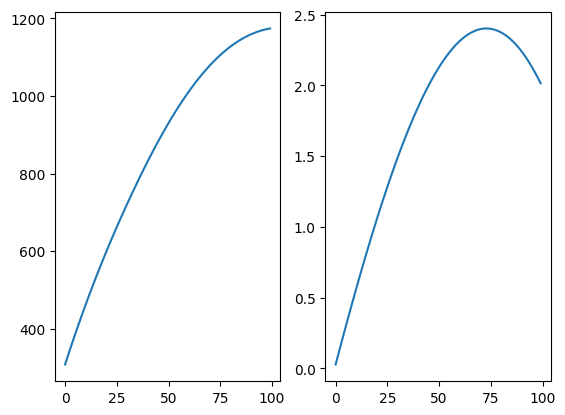

In [19]:
fig,ax = plt.subplots(1,2)
ax[0].plot(T_FVM_1)
ax[1].plot(C_FVM_1)

In [27]:
N_x_2 = 2000 #Medium TAKES APPROX 2.5 Minutes

T_FVM_2, C_FVM_2 = fvm_1D(pde_related_funcs,problem_constants,N_x_2,tol_T,tol_C)


T_FVM_norm_2 = np.linalg.norm(T_FVM_2,2)
C_FVM_norm_2 = np.linalg.norm(C_FVM_2,2)

T_FVM_2 = T_FVM_2[:-1]

fvm_results_2 = {'T_FVM': T_FVM_2,'C_FVM':C_FVM_2,"T_FVM_norm":T_FVM_norm_2,"C_FVM_norm":C_FVM_norm_2}

Elapsed Time 212.404738


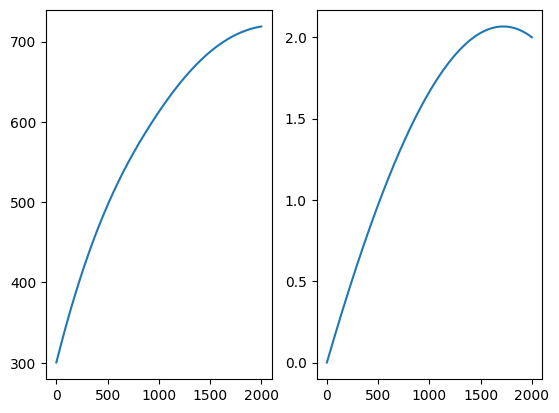

In [28]:
fig,ax = plt.subplots(1,2)
ax[0].plot(T_FVM_2)
ax[1].plot(C_FVM_2)

In [7]:

# N_x_3 = 1000 #High TAKES APPROX 4 Minutes


# T_FVM_3, C_FVM_3 = fvm_1D(pde_related_funcs,problem_constants,N_x_3,tol_T,tol_C)

# T_FVM_3 = T_FVM_3[:-1] #Removing the last element added for robin boundary


# T_FVM_norm_3 = np.linalg.norm(T_FVM_3,2)
# C_FVM_norm_3 = np.linalg.norm(C_FVM_3,2)

# fvm_results_3 = {'T_FVM': T_FVM_3,'C_FVM':C_FVM_3,"T_FVM_norm":T_FVM_norm_3,"C_FVM_norm":C_FVM_norm_3}

In [8]:
# fig,ax = plt.subplots(1,2)
# ax[0].plot(T_FVM_3)
# ax[1].plot(C_FVM_3)

In [23]:
optimizer_algo = "LBFGS" #or Adam
# optimizer_algo = "Adam"
max_iter = 200 #200
# max_iter = 5000

N_f = 2000  #Total number of collocation points 

layers1 = np.array([1,50,50,50,50,1]) #9 hidden layers
layers2 = np.array([1,50,50,50,50,1]) #9 hidden layers

coPINN_constants = {"N_f":N_f,"max_iter" :max_iter,"layers1":layers1,"layers2":layers2,
                    "optimizer_algo":optimizer_algo,"device":device,"fvm_results":fvm_results_2}

In [24]:
coPINN_solver = coPINN_1D_Solver(coPINN_constants,pde_related_funcs,problem_constants,N_x_2)
coPINN_trained = coPINN_solver.train_model(121)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears1): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
  (linears2): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
121
0 Train Loss 248.19286 RD T: 0.8700015649193374 RD C: 1.8156026992534244
1 Train Loss 205.4214 RD T: 0.8624705131658692 RD C: 1.8107349658940495
2 Train Loss 179.50607 RD T: 0.7891930358116059 RD C: 1.810351073317985
3 Train Loss 97.02673 RD T: 0.4883533287433522 RD C: 1.781284636291454
4 Train Loss 27.693932 RD T: 0.12124814954279405 RD C: 1.6237154525957476
5 Train Loss 3.5092516 RD T: 0.053547539712502555 RD C: 0.9292574990944669
6 Train Loss 1.4856346 RD T: 0.07753332806866416 RD C: 0.921

In [25]:
T_PINN,C_PINN = coPINN_trained.test()
# T_PINN = T_PINN.reshape(s[0],s[1])
# C_PINN = C_PINN.reshape(s[0],s[1])

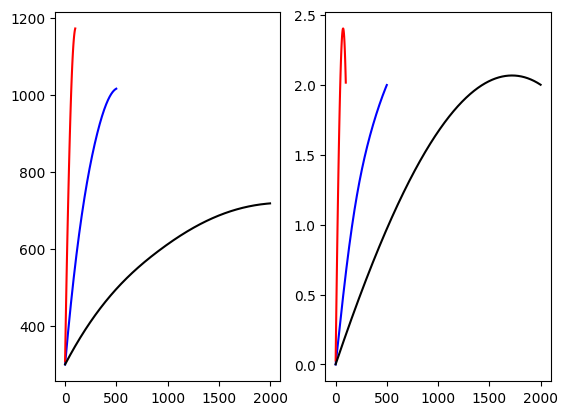

In [29]:

fig,ax = plt.subplots(1,2)
ax[0].plot(T_PINN,'b')
ax[0].plot(T_FVM_1,'r')
ax[0].plot(T_FVM_2,'k')

ax[1].plot(C_PINN,'b')
ax[1].plot(C_FVM_1,'r')
ax[1].plot(C_FVM_2,'k')

In [13]:
np.max(T_FVM_1)

1078.403241959587